
_This supervised learning model will predict good loans versus the bad loans.  The good loans are loan_status = Fully Paid. The bad loans are the loans with a 'loan_status' = Charged Off, Late (31-120 days) and Default.

# Tuning RFC and XGB
 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import scipy

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
sns.set(style="darkgrid")

import timeit
import time

import warnings
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_csv('lending_club_le.csv', index_col=0)
y = df['good_loan_status']
X = df.drop(['good_loan_status'], axis=1)

In [12]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [13]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((70338, 44), (70338,), (17585, 44), (17585,))

___I will run PCA to reduce the Dimensionality___

In [14]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

In [15]:
pca = PCA(n_components=None)
pcaFit = pca.fit(X_train_sc)

In [16]:
pca.explained_variance_ratio_

array([0.08415365, 0.07376762, 0.05553372, 0.05015449, 0.04521346,
       0.03626644, 0.03295183, 0.03099774, 0.02800096, 0.02669504,
       0.02498624, 0.02427042, 0.02423946, 0.02320738, 0.02291807,
       0.02267524, 0.02251938, 0.02206178, 0.02197784, 0.0215134 ,
       0.020932  , 0.02039746, 0.02018989, 0.0195099 , 0.01928526,
       0.01786301, 0.01725146, 0.01660214, 0.01604096, 0.0147758 ,
       0.01373049, 0.01370279, 0.01194363, 0.01119186, 0.01091063,
       0.01038511, 0.00922241, 0.00817459, 0.00770777, 0.00689816,
       0.00633198, 0.00513501, 0.00451696, 0.00319657])

In [17]:
np.cumsum(pca.explained_variance_ratio_)

array([0.08415365, 0.15792127, 0.21345499, 0.26360948, 0.30882295,
       0.34508938, 0.37804121, 0.40903895, 0.43703992, 0.46373495,
       0.4887212 , 0.51299162, 0.53723108, 0.56043846, 0.58335652,
       0.60603177, 0.62855115, 0.65061293, 0.67259077, 0.69410417,
       0.71503617, 0.73543363, 0.75562352, 0.77513342, 0.79441868,
       0.81228169, 0.82953315, 0.84613529, 0.86217625, 0.87695205,
       0.89068254, 0.90438533, 0.91632897, 0.92752083, 0.93843145,
       0.94881656, 0.95803897, 0.96621355, 0.97392132, 0.98081949,
       0.98715147, 0.99228648, 0.99680343, 1.        ])

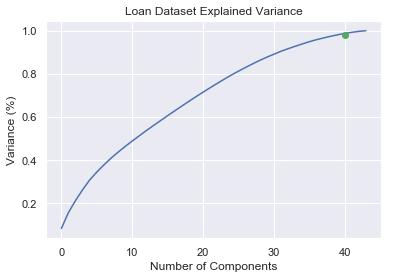

In [9]:
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(40, 0.98081949, 'go')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Loan Dataset Explained Variance')
plt.show()

##### _35 components are able to explain up to 95.998% variance of the data therefore 50 component will be use for all models._

In [18]:
# now limit to 40 components from 45, which should be around 98% hopefully
# pipeline = Pipeline(['scaling',StandardScaler()),'pca',PCA(n_components=33)])
# X_train_sc_pca=pipeline.fit_transform(X_train)
#X_test_sc_pca = pipeline.fit(X_test)

pca = PCA(n_components=40)
pcaFit = pca.fit(X_train_sc)  # get eigens

X_train_sc_pca = pca.fit_transform(X_train_sc)  # apply the eigens
X_test_sc_pca = pca.transform(X_test_sc)

In [19]:
X_train_sc_pca.shape, X_test_sc_pca.shape, y_train.shape, y_test.shape

((70338, 40), (17585, 40), (70338,), (17585,))

# Random Forest tuning
I am tuning the following features and I will apply adaboost to the tuned model. The model will run a 3 fold cross validation.

    - 'max_depth'
    - 'min_samples_leaf'
    - 'n_estimators'
    - 'max_features'
    - 'min_samples_split'

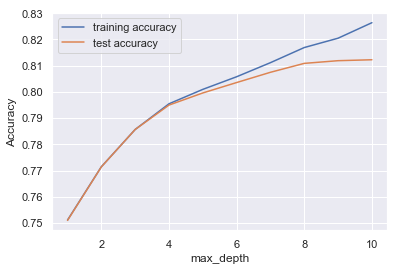

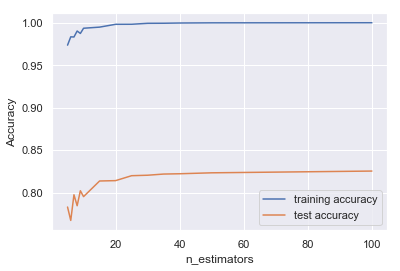

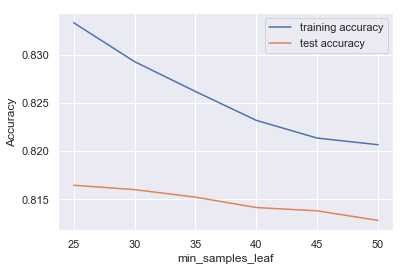

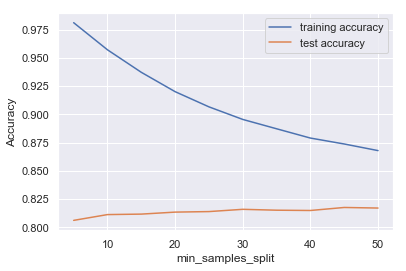

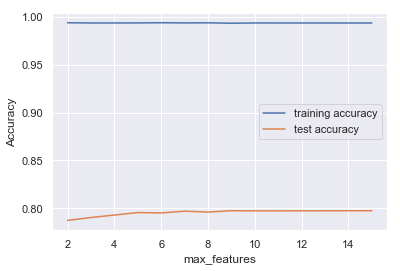

--- 877.7044 seconds --- 


In [20]:
# parameters to build the model on

start_time = time.time()

hyperparameter = ['max_depth',
                  'n_estimators',
                  'min_samples_leaf',
                  'min_samples_split',
                  'max_features']

range = [
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    [5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 50, 100],
    [25, 30, 35, 40, 45, 50],
    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    [2, 3, 5, 6, 7, 8, 9, 10, 15]
]
for var in zip(hyperparameter, range):

    parameters = {"{}".format(var[0]): var[1]}
    # instantiate the model
    rf = RandomForestClassifier()

    # fit tree on training data
    rfgrid = GridSearchCV(rf, parameters,
                          cv=3,
                          scoring="accuracy")
    rfgrid.fit(X_train_sc_pca, y_train)
    scores = rfgrid.cv_results_

    plt.figure()
    plt.plot(scores['param_'+var[0]],
             scores["mean_train_score"],
             label="training accuracy")
    plt.plot(scores['param_'+var[0]],
             scores["mean_test_score"],
             label="test accuracy")
    plt.xlabel(var[0])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

___Using the parameters above to fine tune to find the best model___

In [21]:
# Create the parameter grid based on the results of random search

param_grid = {
    'max_depth': [2, 3, 5, 6],
    'n_estimators': [80,100],
    'min_samples_leaf': [50, 60, 70],
    'min_samples_split': [50, 60, 70, 80],
    'max_features': [8,10,14]
}
# Create a based model
rf_tree = RandomForestClassifier()
# Instantiate the grid search model
rfgrid_search = GridSearchCV(estimator=rf_tree,
                             param_grid=param_grid,
                             cv=3, n_jobs=-1, verbose=1)

In [22]:
# Fit the grid search to the data
start_time = time.time()
rfgrid_search.fit(X_train_sc_pca, y_train)

stop = timeit.default_timer()
print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 92.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 110.0min finished


--- 6642.8837 seconds --- 


In [23]:
# printing the optimal accuracy score and hyperparameters
print('The best RFC accuracy score is {0:.4f}'.format(
    rfgrid_search.best_score_),
    'and has the parameters\n', rfgrid_search.best_params_)

The best RFC accuracy score is 0.8112 and has the parameters
 {'max_depth': 6, 'max_features': 14, 'min_samples_leaf': 50, 'min_samples_split': 60, 'n_estimators': 80}


In [29]:
# model with the best hyperparameters
rf_final = RandomForestClassifier(bootstrap=True,
                                  max_depth=6,
                                  min_samples_leaf=50,
                                  min_samples_split=60,
                                  max_features=14,
                                  n_estimators=80)

Tuned RFC has an accuracy score of __81.12%__

------ 

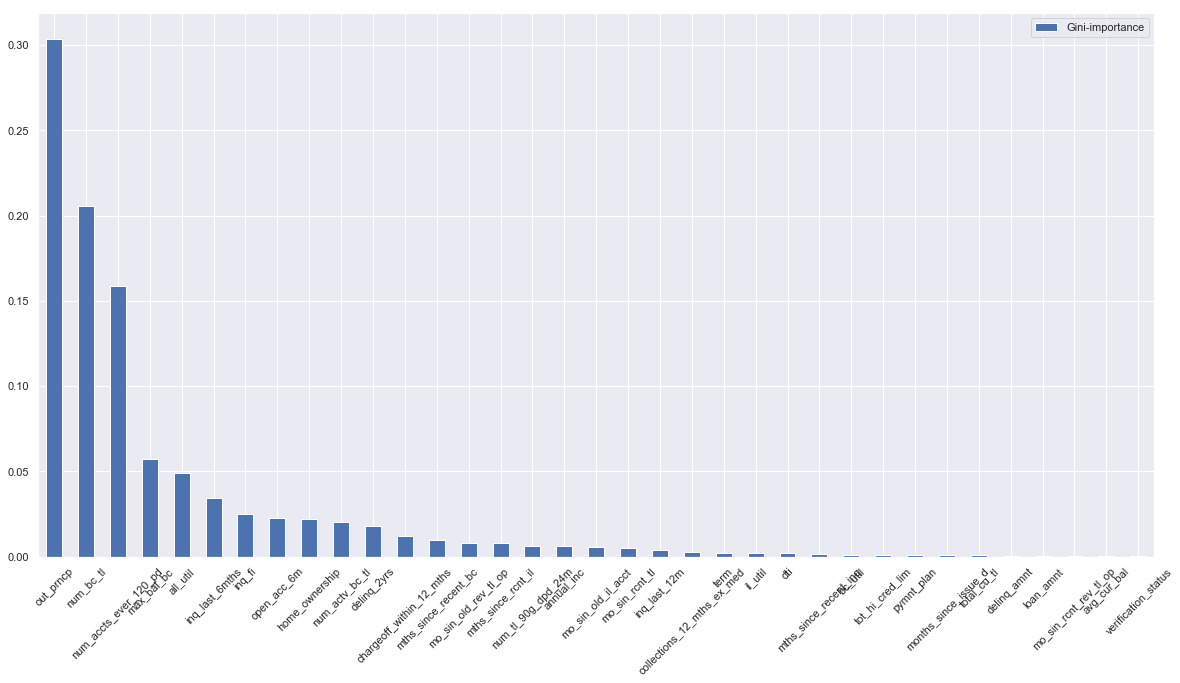

In [25]:
feats = {}  # a dict to hold feature_name: feature_importance
rf_final.fit(X_train_sc_pca, y_train)
for feature, importance in zip(X.columns, rf_final.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(
    feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance',
                        ascending=False).head(35).plot(kind='bar',
                                                      rot=45,
                                                      figsize=(20, 10))

The top 10 features to be used in unsupervised clustering

In [26]:
importances.sort_values(by='Gini-importance',
                        ascending=False).head(10)

,Gini-importance
out_prncp,0.303716
num_bc_tl,0.205753
num_accts_ever_120_pd,0.158923
max_bal_bc,0.057104
all_util,0.049250
inq_last_6mths,0.034221
inq_fi,0.025177
open_acc_6m,0.022489
home_ownership,0.022007
num_actv_bc_tl,0.020081


-----

# Applying the AdaBoostClassifier to Random Forest

In [28]:
# adaboost with the RF tree as base estimator
start_time = time.time()
estimators = np.arange(1, 40, 1)

ada_scores = []
for n_est in estimators:
    ABC = AdaBoostClassifier(base_estimator=rf_final,
                             n_estimators=n_est)

    res = cross_val_score(ABC,
                          X_train_sc_pca,
                          y_train, cv=3)

    print("\nThe average accuracy score: {0:.4f}".format(np.mean(res)), n_est)
print("--- {:.4f} seconds --- ".format((time.time() - start_time)))


The average accuracy score: 0.8039 1

The average accuracy score: 0.8146 2

The average accuracy score: 0.8202 3

The average accuracy score: 0.8244 4

The average accuracy score: 0.8286 5

The average accuracy score: 0.8308 6

The average accuracy score: 0.8329 7

The average accuracy score: 0.8345 8

The average accuracy score: 0.8356 9

The average accuracy score: 0.8366 10

The average accuracy score: 0.8369 11

The average accuracy score: 0.8383 12

The average accuracy score: 0.8390 13

The average accuracy score: 0.8401 14

The average accuracy score: 0.8400 15

The average accuracy score: 0.8403 16

The average accuracy score: 0.8407 17

The average accuracy score: 0.8411 18

The average accuracy score: 0.8412 19

The average accuracy score: 0.8411 20

The average accuracy score: 0.8415 21

The average accuracy score: 0.8423 22

The average accuracy score: 0.8420 23

The average accuracy score: 0.8424 24

The average accuracy score: 0.8425 25

The average accuracy score: 0.842

In [30]:
ada_final = AdaBoostClassifier(base_estimator=rf_final,
                                         n_estimators=38)

_With ADAboost RaandomForest (n_estimator = 37) has an accuracy score: ___84.37%___, this is a ___3.21%___ improvement from the RFC model score of ___81.12___.

------ 

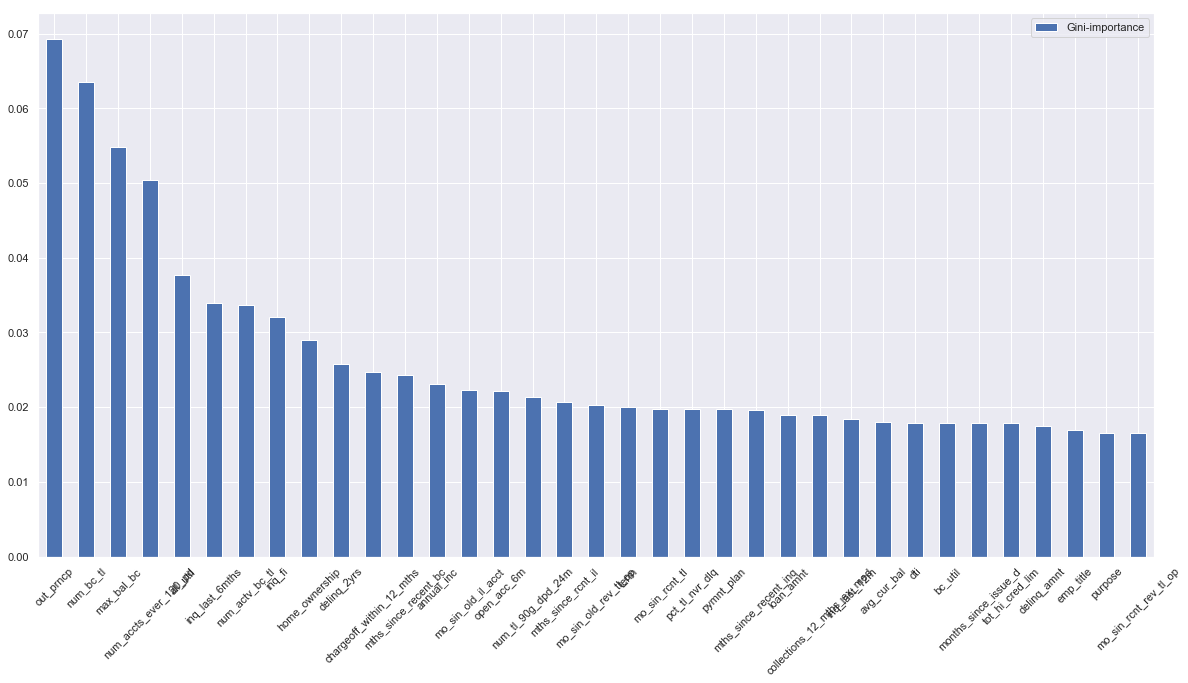

In [31]:
feats = {}  # a dict to hold feature_name: feature_importance
ada_final.fit(X_train_sc_pca, y_train)
for feature, importance in zip(X.columns, ada_final.feature_importances_):
    feats[feature] = importance

ada_importances = pd.DataFrame.from_dict(
    feats, orient='index').rename(columns={0: 'Gini-importance'})
ada_importances.sort_values(by='Gini-importance',
                        ascending=False).head(35).plot(kind='bar',
                                                      rot=45,
                                                      figsize=(20, 10))

In [32]:
importances.sort_values(by='Gini-importance',
                        ascending=False).head(10)

,Gini-importance
out_prncp,0.303716
num_bc_tl,0.205753
num_accts_ever_120_pd,0.158923
max_bal_bc,0.057104
all_util,0.049250
inq_last_6mths,0.034221
inq_fi,0.025177
open_acc_6m,0.022489
home_ownership,0.022007
num_actv_bc_tl,0.020081


_Feature importance of the boosted Random Forest.  Past medical expenses and open accounts are big factors in getting approved for a loan._

-------------

# Extreme Gradiant Boosting Tuning

I am tuning the following features to get the best score
    - 'max_depth'
    - 'learning_rate'
    - 'n_estimators'
    - 'subsample'
    - 'colsample_bytree'
    - 'colsample_bylevel'

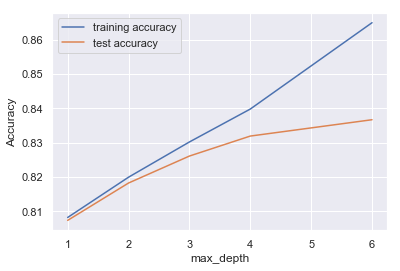

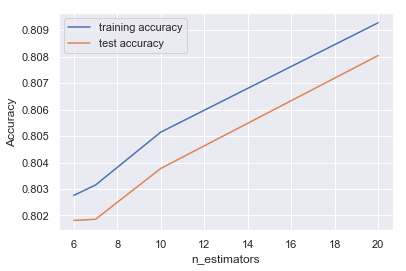

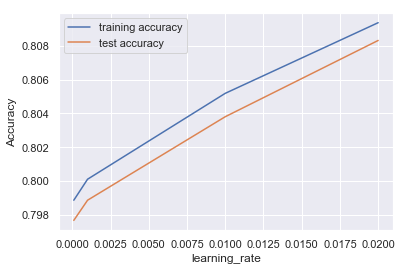

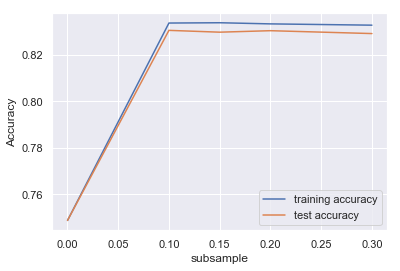

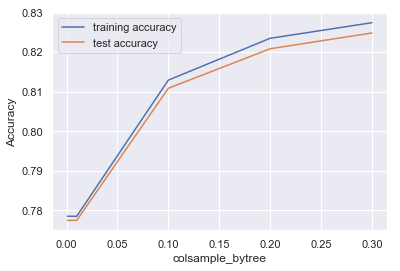

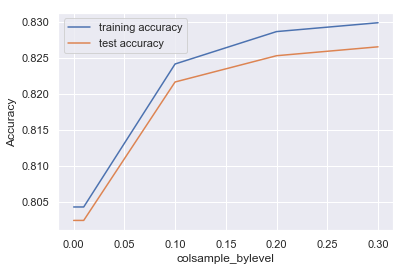

--- 1021.0974 seconds --- 


In [33]:
start_time = time.time()


# parameters to build the model on
hyperparameter = ['max_depth', 'n_estimators', 'learning_rate',
                  'subsample', 'colsample_bytree', 'colsample_bylevel']

range = [
    [1, 2, 3, 4, 6],
    [6, 7,10, 20],
    [0.0001, 0.001, 0.01, 0.02],
    [0.0001, 0.1, 0.15, 0.2, 0.3],
    [0.001, 0.01, 0.1, 0.2, 0.3],
    [0.0001, 0.001, 0.01,0.1, 0.2, 0.3],
]
for var in zip(hyperparameter, range):

    parameters = {"{}".format(var[0]): var[1]}
    # instantiate the model
    XGB = XGBClassifier()

    # fit tree on training data
    XGB = GridSearchCV(XGB, parameters,
                       cv=3,
                       scoring="accuracy")  # you can change scoring functions right here.
    XGB.fit(X_train_sc_pca, y_train)
    scores = XGB.cv_results_

    plt.figure()
    plt.plot(scores['param_'+var[0]],
             scores["mean_train_score"],
             label="training accuracy")
    plt.plot(scores['param_'+var[0]],
             scores["mean_test_score"],
             label="test accuracy")
    plt.xlabel(var[0])
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

___now let's plug in the values to get the final parameters___

In [34]:
param_grid = {
    'max_depth': [1, 2, 3],
    'n_estimators': [2,4,5],
    'learning_rate': [0.00001,0.1,0.05],
    'subsample': [0.0001, 0.001, 0.01],
    'colsample_bytree': [0.0001, 0.001, 0.01],
    'colsample_bylevel': [0.0001, 0.001, 0.0], }
# Create a based model
xgb = XGBClassifier()
# Instantiate the grid search model
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid,
                        cv=3, n_jobs=-1, verbose=1)

In [35]:
# Fit the grid search to the data
start_time = time.time()
xgb_grid.fit(X_train_sc_pca, y_train)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 2187 out of 2187 | elapsed: 15.6min finished


--- 938.8986 seconds --- 


In [36]:
# printing the optimal accuracy score and hyperparameters
print('The best XGB accuracy score is {0:.4f}'.format(
    xgb_grid.best_score_), 'with parameters\n', xgb_grid.best_params_)

The best XGB accuracy score is 0.7487 with parameters
 {'colsample_bylevel': 0.0001, 'colsample_bytree': 0.0001, 'learning_rate': 1e-05, 'max_depth': 1, 'n_estimators': 4, 'subsample': 0.01}


In [37]:
xgb_param_grid = {
    'max_depth': [1],
    'n_estimators': [4],
    'learning_rate': [1e-05],
    'subsample': [0.01],
    'colsample_bytree': [0.0001],
    'colsample_bylevel': [0.0001]}
xgb_final = XGBClassifier()

xgb_grid_f = GridSearchCV(estimator=xgb_final, param_grid=xgb_param_grid,
                          cv=3, n_jobs=-1, verbose=1)
xgb_grid_f.fit(X_train_sc_pca, y_train)
print('We can get accuracy of {0:.4f}'.format(
    xgb_grid_f.best_score_), 'with parameters\n', xgb_grid_f.best_params_)

print("--- {:.4f} seconds --- ".format((time.time() - start_time)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


We can get accuracy of 0.7487 with parameters
 {'colsample_bylevel': 0.0001, 'colsample_bytree': 0.0001, 'learning_rate': 1e-05, 'max_depth': 1, 'n_estimators': 4, 'subsample': 0.01}
--- 20720.1425 seconds --- 


_The accuracy score for Extreme Gradient Boost:_ ___74.91%___

In [38]:
xgb.fit(X_train_sc_pca, y_train)
xgb_fea_imp = pd.DataFrame(list(xgb.get_booster().get_fscore().items()),
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)
print('', xgb_fea_imp)

    feature  importance
0       f5         111
1      f27          90
3      f25          79
2      f10          70
4       f4          54
5      f11          41
10     f12          40
6       f3          37
11      f8          26
13     f23          24
7       f1          22
14     f26          22
12     f35          17
9       f7          15
15     f32           8
21     f22           6
28     f24           5
16     f17           5
8      f28           5
17      f2           4
23     f20           4
24     f19           3
18      f6           2
20     f14           2
19      f0           1
22     f18           1
25     f34           1
26     f29           1
27     f31           1
29     f39           1
30     f37           1
31     f15           1


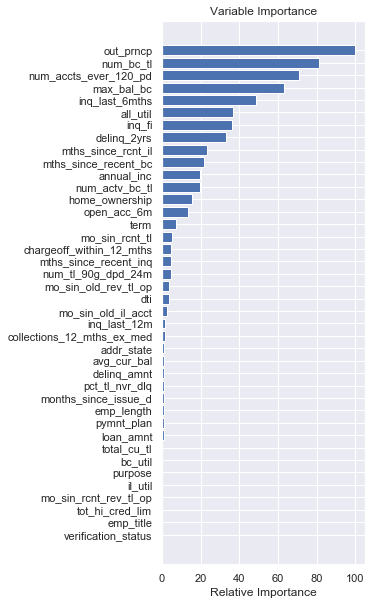

In [39]:
fig = plt.figure(figsize=(8, 10))
feature_importance = xgb.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

-----

Tuning andom forest with ada boost has the best accuracy score.  84.05% of the time it is able to tell whether a long is good or bad. This is beats the baseline (77.37%) by 8.38%.  XGB doesn't beat the baseline. Now I will use the tuned values to compare the accuracy of all the models.  Looking at the features, there are more that can clearly be removed before modeling as they don't add value to the model.

_With ADAboost RaandomForest (n_estimator = 18) has an accuracy score: ___84.05%___, this is a ___3.11%___ improvement from the RFC model score of ___80.94___.